In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np 
import scipy.optimize as op
import scipy.stats as ss
from chainconsumer import ChainConsumer # sudo pip install chainconsumer

# For full documentation on ChainConsumer - refer to: 

# https://samreay.github.io/ChainConsumer/index.html

from IPython.display import Image
from IPython.display import IFrame 

# Settings for plots
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})
fontSize = 20.0
figSize  = (10,6)

np.random.seed(4)

# Data and Model

Suppose we have noisy data, which has been generated from a sinusoidal function. We assume the standard deviation of each datapoint is the same for all datapoints and is $\sigma=0.2$. The model (assume we know the correct model) which we are trying to fit is 

$$y=a\,\textrm{sin}\left(\omega x+\phi\right)+\delta$$

where $\left(a,\,\omega,\,\phi,\,\delta\right)$ are the set of parameters whose distributions we want to learn.

In [2]:
IFrame("data_sin.pdf", width=500, height=400)

## Load the data

In [3]:
data  = np.loadtxt('sin_data.txt')
x     = data[:,0]
y     = data[:,1]
sigma = data[:,2] 

## Define the log-likelihood

In [4]:
def loglikelihood(params, x, y):
    a, omega, phi, delta = params
    y_model    = a*np.sin(omega*x + phi) + delta
    chi_square = np.dot((y - y_model)/sigma, (y-y_model)/sigma) 
    return -0.5 * chi_square - 0.5 * len(x) * np.log(2.0 * np.pi * sigma[0])

Suppose, we want to have an idea of the best-fit parameters. Before running the MCMC, we can use an optimisation algorithm to determine these values.

In [5]:
nll      = lambda *args: -2*loglikelihood(*args) # the negative loglikelihood (simply the chi-square)
result   = op.minimize(nll, [1.0, 1.0, 1.0, 1.0], args=(x, y))
theta_ml = np.array(result["x"])
print theta_ml

[ 2.05504043  1.00984193  0.19368868  0.53328364]


## Define the priors

In [6]:
a_prior     = ss.uniform(theta_ml[0] - 0.5, 1.0)
omega_prior = ss.uniform(theta_ml[1] - 0.5, 1.0)
phi_prior   = ss.uniform(theta_ml[2] - 0.5, 1.0)
delta_prior = ss.uniform(theta_ml[3] - 0.5, 1.0)

def logPrior(params):
    a, omega, phi, delta = params
    a_pdf     = a_prior.pdf(a)
    omega_pdf = omega_prior.pdf(omega)
    phi_pdf   = phi_prior.pdf(phi)
    delta_pdf = delta_prior.pdf(delta)
    prior     = a_pdf * omega_pdf * phi_pdf * delta_pdf 
    if prior <= 0:
        return -np.inf
    else:
        return np.log(prior)

## MCMC - The Metropolis-Hastings Algorithm

In [7]:
def decision(params_ini, params_fin):
    log_likelihood_ini = loglikelihood(params_ini, x, y)
    log_likelihood_fin = loglikelihood(params_fin, x, y)
    
    log_prior_ini  = logPrior(params_ini)
    log_prior_fin  = logPrior(params_fin)
    
    log_ratio_post = (log_likelihood_fin + log_prior_fin) - (log_likelihood_ini + log_prior_ini)
    
    return log_ratio_post

## Settings for the MCMC

In [8]:
N      = 1E5
matrix = np.zeros(shape = (N, 4))
count  = 0

# Draw initial samples of the parameters from the proposal distributions
a_ini     = a_prior.rvs(1)
omega_ini = omega_prior.rvs(1)
phi_ini   = phi_prior.rvs(1)
delta_ini = delta_prior.rvs(1)
parameters_initial = np.array([a_ini, omega_ini, phi_ini, delta_ini])

In [9]:
for i in range(int(N)):
    step = np.array([np.random.normal(0., 0.01), np.random.normal(0., 0.01), np.random.normal(0., 0.005), np.random.normal(0., 0.005)]).reshape(4,1)
    parameters_final   = parameters_initial + step
    
    r = decision(parameters_initial, parameters_final)
    
    if r>np.log(np.random.rand()):
        count += 1
        parameters_initial = parameters_final
    else:
        parameters_initial = parameters_initial
            
    matrix[i] = parameters_initial.reshape(4,)
print '\nThe acceptance rate is %2.2f' %(float(count)/float(N) * 100.0)


The acceptance rate is 47.60


## Burn-in

In [10]:
fraction_discard = 0.10
chain = matrix[int(fraction_discard*N):]

<IPython.core.display.Javascript object>


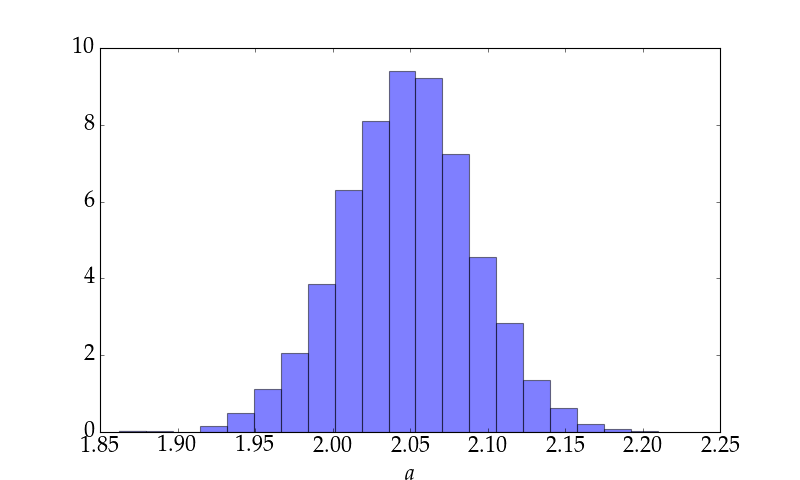

In [11]:
plt.figure(figsize = figSize)
plt.hist(chain[:,0], normed = True, bins = 20, alpha = 0.5)
plt.xlabel('$a$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize = fontSize)
plt.tick_params(axis='y', labelsize = fontSize)
plt.show()

<IPython.core.display.Javascript object>


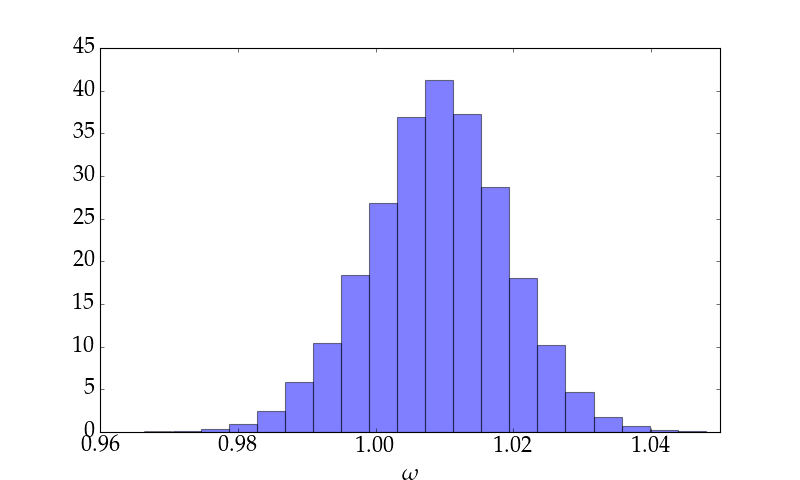

In [12]:
plt.figure(figsize = figSize)
plt.hist(chain[:,1], normed = True, bins = 20, alpha = 0.5)
plt.xlabel('$\omega$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize = fontSize)
plt.tick_params(axis='y', labelsize = fontSize)
plt.show()

<IPython.core.display.Javascript object>


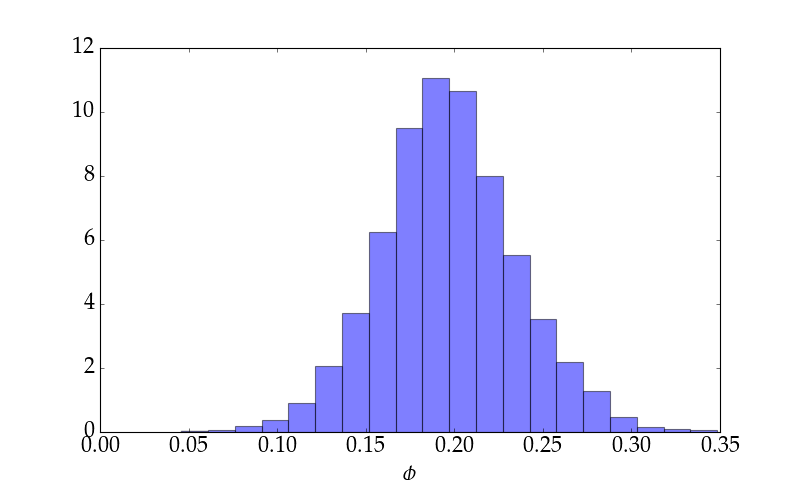

In [13]:
plt.figure(figsize = figSize)
plt.hist(chain[:,2], normed = True, bins = 20, alpha = 0.5)
plt.xlabel('$\phi$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize = fontSize)
plt.tick_params(axis='y', labelsize = fontSize)
plt.show()

<IPython.core.display.Javascript object>


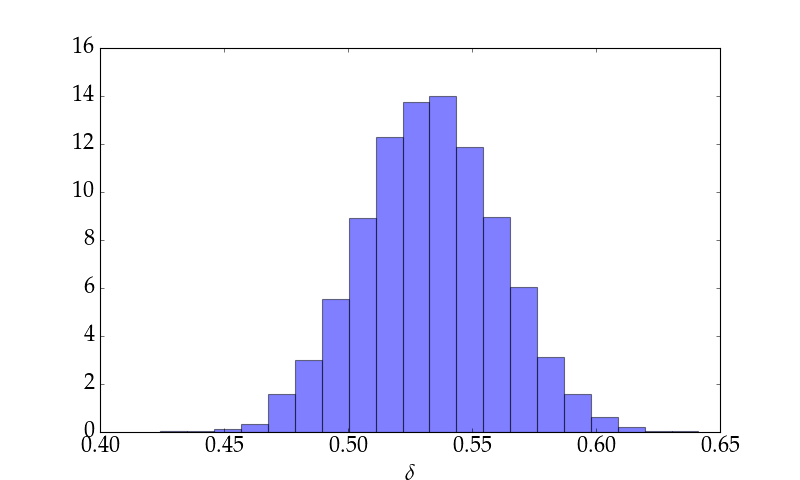

In [14]:
plt.figure(figsize = figSize)
plt.hist(chain[:,3], normed = True, bins = 20, alpha = 0.5)
plt.xlabel('$\delta$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize = fontSize)
plt.tick_params(axis='y', labelsize = fontSize)
plt.show()

## Summary Statistics

In [15]:
a, omega, phi, delta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84], axis=0)))

print("""MCMC result:
    a     = {0[0]:.2f} +{0[1]:.2f} -{0[2]:.2f} (truth: {1:.2f})
    omega = {2[0]:.2f} +{2[1]:.2f} -{2[2]:.2f} (truth: {3:.2f})
    phi   = {4[0]:.2f} +{4[1]:.2f} -{4[2]:.2f} (truth: {5:.2f})
    delta = {6[0]:.2f} +{6[1]:.2f} -{6[2]:.2f} (truth: {7:.2f})
""".format(a, 2.00, omega, 1.00, phi, 0.20, delta, 0.50))

MCMC result:
    a     = 2.05 +0.04 -0.04 (truth: 2.00)
    omega = 1.01 +0.01 -0.01 (truth: 1.00)
    phi   = 0.20 +0.04 -0.04 (truth: 0.20)
    delta = 0.53 +0.03 -0.03 (truth: 0.50)



## Correlation Between Parameters

In [ ]:
c = ChainConsumer().add_chain(chain, parameters=["$a$", "$\omega$", "$\phi$", "$\delta$"])
c.configure_bar(summary=False).configure_general(bins=0.1)
c.configure_contour(cloud=False, sigmas=[0, 1, 2, 3])
fig = c.plot(filename="Triangle_plot.png",figsize=(10, 10),truth=[2.00, 1.00, 0.20, 0.50]) 

<IPython.core.display.Javascript object>